# Use XGBoost to classify tumors with `ibm-watson-machine-learning`

This notebook contains steps and code to get data from the IBM Watson Studio Community, create a predictive model, and start scoring new data. It introduces commands for getting data and for basic data cleaning and exploration, model training, model persistance to Watson Machine Learning repository, model deployment, and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.7, XGBoost, and scikit-learn 0.23.1.

You will use a publicly available data set, the Breast Cancer Wisconsin (Diagnostic) Data Set, to train an XGBoost Model to classify breast cancer tumors (as benign or malignant) from 569 diagnostic images based on measurements such as radius, texture, perimeter and area. XGBoost is short for “E**x**treme **G**radient **Boost**ing”.

The XGBoost classifier makes its predictions based on the majority vote from collection of models which are a set of classification trees. It uses the combination of weak learners to create a single strong learner. It’s a sequential training process, whereby new learners focus on the misclassified examples of previous learners.


## Learning goals

You will learn how to:

-  Load a CSV file into numpy array
-  Explore data
-  Prepare data for training and evaluation
-  Create an XGBoost machine learning model
-  Train and evaluate a model
-  Use cross-validation to optimize model's hyperparameters
-  Persist a model in Watson Machine Learning repository
-  Deploy a model for online scoring
-  Score sample data


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Load and explore the data](#load)
3.	[Create the XGBoost model](#model)
4.	[Persist model](#upload)
5.	[Deployment](#deploy)
6.  [Score the model](#score)
7.  [Clean up](#cleanup)
8.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `password`.

In [ ]:
username = 'PASTE YOUR USERNAME HERE'
password = 'PASTE YOUR PASSWORD HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [2]:
wml_credentials = {
    "username": username,
    "password": password,
    "url": url,
    "instance_id": 'openshift',
    "version": '3.5'
}

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="https://ibm.github.io/watson-machine-learning-sdk//" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install -U ibm-watson-machine-learning

In [3]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd3.5/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [ ]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [4]:
client.set.default_space(space_id)

'SUCCESS'

<a id="load"></a>
## 2. Load and explore the data

In this section you will load the data as a numpy array and perform a basic exploration.

To load the data as a numpy array, user `wget` to download the data, then use the `genfromtxt` method to read the data.

**Example**: First, you need to install the required packages. You can do this by running the following code. Run it only one time.<BR><BR>

In [ ]:
!pip install wget --upgrade

In [5]:
import wget, os

WisconsinDataSet = 'BreastCancerWisconsinDataSet.csv' 
if not os.path.isfile(WisconsinDataSet):
    link_to_data = 'https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cpd3.5/data/cancer/' + WisconsinDataSet
    print(link_to_data)
    WisconsinDataSet = wget.download(link_to_data)

print(WisconsinDataSet)

BreastCancerWisconsinDataSet.csv


The csv file **BreastCancerWisconsinDataSet.csv** is downloaded. Run the code in the next cells to load the file to the numpy array.

In [6]:
import numpy as np

np_data = np.genfromtxt(WisconsinDataSet, delimiter=',', names=True, dtype=None, encoding='utf-8')
print(np_data[0])

(842302, 'M', 17.99, 10.38, 122.8, 1001., 0.1184, 0.2776, 0.3001, 0.1471, 0.2419, 0.07871, 1.095, 0.9053, 8.589, 153.4, 0.006399, 0.04904, 0.05373, 0.01587, 0.03003, 0.006193, 25.38, 17.33, 184.6, 2019., 0.1622, 0.6656, 0.7119, 0.2654, 0.4601, 0.1189)


Run the code in the next cell to view the feature names and data storage types.

In [7]:
# Display the feature names and data storage types.
print(np_data.dtype)

[('id', '<i8'), ('diagnosis', '<U1'), ('radius_mean', '<f8'), ('texture_mean', '<f8'), ('perimeter_mean', '<f8'), ('area_mean', '<f8'), ('smoothness_mean', '<f8'), ('compactness_mean', '<f8'), ('concavity_mean', '<f8'), ('concave_points_mean', '<f8'), ('symmetry_mean', '<f8'), ('fractal_dimension_mean', '<f8'), ('radius_se', '<f8'), ('texture_se', '<f8'), ('perimeter_se', '<f8'), ('area_se', '<f8'), ('smoothness_se', '<f8'), ('compactness_se', '<f8'), ('concavity_se', '<f8'), ('concave_points_se', '<f8'), ('symmetry_se', '<f8'), ('fractal_dimension_se', '<f8'), ('radius_worst', '<f8'), ('texture_worst', '<f8'), ('perimeter_worst', '<f8'), ('area_worst', '<f8'), ('smoothness_worst', '<f8'), ('compactness_worst', '<f8'), ('concavity_worst', '<f8'), ('concave_points_worst', '<f8'), ('symmetry_worst', '<f8'), ('fractal_dimension_worst', '<f8')]


In [8]:
# Display the number of records and features.
print('Number of rows: {}'.format(np_data.size))
print('Number of columns: {}'.format(len(np_data[0])))

Number of rows: 569
Number of columns: 32


You can see that the data set has 569 records and 32 features.

<a id="model"></a>
## 3. Create an XGBoost model

In this section you will learn how to train and test an XGBoost model.

- [3.1. Prepare the data](#prepare)
- [3.2. Create the XGBoost model](#create)

**Note:** Update `xgboost` to ensure you have `1.3.3` version.

In [ ]:
!pip install -U xgboost==1.3.3

### 3.1. Prepare data<a id="prepare"></a>

Now, you can prepare your data for model building. You will use the `diagnosis` column as your target variable so you must remove it from the set of predictors. You must also remove the `id` variable.

In [19]:
y = 1 * (np_data['diagnosis'] == 'M')
X = np.array([list(r)[2:] for r in np_data])

Split the data set into: 
- Train data set
- Test data set

In [20]:
# Split the data set and create two data sets.
# from sklearn.cross_validation import train_test_split 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=143)

In [21]:
# List the number of records in each data set.
print("Number of training records: " + str(X_train.shape[0]))
print("Number of testing records : " + str(X_test.shape[0]))

Number of training records: 369
Number of testing records : 200


The data has been successfully split into two data sets:
- The train data set, which is the largest group, will be used for training
- The test data set will be used for model evaluation and is used to test the assumptions of the model

### 3.2. Create the XGBoost model<a id="create"></a>

Start by importing the necessary libraries.

In [22]:
# Import the libraries you need to create the XGBoost model.
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#### 3.2.1. Create an XGBoost classifier

In this section you create an XGBoost classifier with default hyperparameter values and you will call it *xgb_model*. 

**Note** The next sections show you how to improve this base model.

**Note**: Usage of default or `n_jobs=-1` parameter in XGBoost classifier is not recommended as underlying process often cannot correctly discover number of CPUs / threads allowed.  
Other ways to controll the number of cores used is through environmental variables `OMP_NUM_THREADS` and `MKL_NUM_THREADS`, which should be set by default if this notebook is executed inside 
Watson Studio.


In [23]:
# Create the XGB classifier, xgb_model.
xgb_model = XGBClassifier(use_label_encoder=False, n_jobs=1)

Display the default parameters for *xgb_model*.

In [24]:
# List the default parameters.
print(xgb_model.get_xgb_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


Now that your XGBoost classifier, *xgb_model*, is set up, you can train it by invoking the fit method. You will also evaluate *xgb_model* while the train and test data are being trained.

In [25]:
# Train and evaluate.
xgb_model.fit(X_train, y_train, eval_metric=['error'], eval_set=[((X_train, y_train)),(X_test, y_test)])

[0]	validation_0-error:0.01626	validation_1-error:0.06000
[1]	validation_0-error:0.00813	validation_1-error:0.06000
[2]	validation_0-error:0.00813	validation_1-error:0.05500
[3]	validation_0-error:0.00542	validation_1-error:0.05000
[4]	validation_0-error:0.00542	validation_1-error:0.05000
[5]	validation_0-error:0.00271	validation_1-error:0.04500
[6]	validation_0-error:0.00271	validation_1-error:0.05500
[7]	validation_0-error:0.00271	validation_1-error:0.05000
[8]	validation_0-error:0.00271	validation_1-error:0.05000
[9]	validation_0-error:0.00271	validation_1-error:0.05000
[10]	validation_0-error:0.00271	validation_1-error:0.05500
[11]	validation_0-error:0.00271	validation_1-error:0.05000
[12]	validation_0-error:0.00271	validation_1-error:0.04500
[13]	validation_0-error:0.00271	validation_1-error:0.04000
[14]	validation_0-error:0.00271	validation_1-error:0.04000
[15]	validation_0-error:0.00271	validation_1-error:0.03000
[16]	validation_0-error:0.00271	validation_1-error:0.03500
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

**Note:** You can also use a pandas dataFrame instead of the numpy array.

Plot the model performance evaluated during the training process to assess model overfitting.

In [26]:
# Import the library
from matplotlib import pyplot

%matplotlib inline

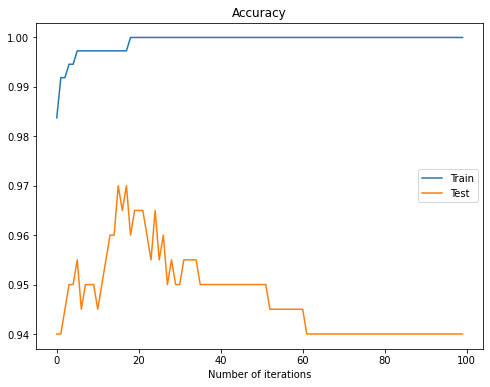

In [27]:
# Plot and display the performance evaluation
xgb_eval = xgb_model.evals_result()
eval_steps = range(len(xgb_eval['validation_0']['error']))

fig, ax = pyplot.subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [1-x for x in xgb_eval['validation_0']['error']], label='Train')
ax.plot(eval_steps, [1-x for x in xgb_eval['validation_1']['error']], label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations');

You can see that there is model overfitting, and there is a decrease in model accuracy after about 60 iterations 

Select the trained model obtained after 30 iterations.

In [28]:
# Select trained model.
n_trees = 30
y_pred = xgb_model.predict(X_test, ntree_limit= n_trees)

In [29]:
# Check the accuracy of the trained model.
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.1f%%" % (accuracy * 100.0))

Accuracy: 95.0%


**Note:** You will use the accuracy value obtained on the test data to compare the accuracy of the model with default parameters to the accuracy of the model with tuned parameters.

#### 3.2.2. Use grid search and cross-validation to tune the model 

You can use grid search and cross-validation to tune your model to achieve better accuracy.

XGBoost has an extensive catalog of hyperparameters which provides great flexibility to shape an algorithm’s desired behavior. Here you will the optimize the model tuning which adds an L1 penalty (`reg_alpha`).

Use a 5-fold cross-validation because your training data set is small.

In the cell below, create the XGBoost pipeline and set up the parameter grid for the search.

In [30]:
# Create XGBoost pipeline, set up parameter grid.
xgb_model_gs = XGBClassifier(eval_metric=['error'], use_label_encoder=False, n_jobs=1)
parameters = {'reg_alpha': [0.0, 1.0], 'reg_lambda': [0.0, 1.0], 'n_estimators': [n_trees], 'seed': [1337]}

Use ``GridSearchCV`` to search for the best parameters over the parameters values that were specified in the previous section.

In [31]:
# Search for the best parameters.
clf = GridSearchCV(xgb_model_gs, parameters, scoring='accuracy', cv=5, verbose=-1, n_jobs=1, refit=True)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    4.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.4s finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric=['error'], gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=

From the grid scores, you can see the performance result of all parameter combinations including the best parameter combination based on model performance.

Display the accuracy estimated using cross-validation and the hyperparameter values for the best model.

In [32]:
print("Best score: %.1f%%" % (clf.best_score_*100))
print("Best parameter set: %s" % (clf.best_params_))

Best score: 95.9%
Best parameter set: {'n_estimators': 30, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'seed': 1337}


Display the accuracy of best parameter combination on the test set.

In [33]:
y_pred = clf.best_estimator_.predict(X_test, ntree_limit= n_trees)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.1f%%" % (accuracy * 100.0))

Accuracy: 96.5%


The accuracy on test set is about the same for tuned model as it is for the trained model that has default hyperparameters values, even though the selected hyperparameters are different to the default parameters.

#### 3.2.3. Model with pipeline data preprocessing

Here you learn how to use the XGBoost model within the scikit-learn pipeline. 

Let's start by importing the required objects.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [35]:
pca = PCA(n_components=10)
xgb_model_pca = XGBClassifier(n_estimators=n_trees, verbosity=1, eval_metric=['error'], use_label_encoder=False, n_jobs=1)
pipeline = Pipeline(steps=[('pca', pca), ('xgb', xgb_model_pca)])

In [36]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=10)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric=['error'],
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=30,
                               n_jobs=12, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=1))])

Now you are ready to evaluate accuracy of the model trained on the reduced set of features.

In [37]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.1f%%" % (accuracy * 100.0))
pipeline

Accuracy: 94.5%


Pipeline(steps=[('pca', PCA(n_components=10)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric=['error'],
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=30,
                               n_jobs=12, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=1))])

You can see that this model has a similar accuracy to the model trained using default hyperparameter values.

Let's see how you can save your XGBoost pipeline using the WML service instance and deploy it for online scoring.

<a id="upload"></a>
## 4. Persist model

In this section you learn how to use the Python client libraries to store your XGBoost model in the WML repository.

### Save the XGBoost model to the WML Repository

Save the model artifact as *XGBoost model for breast cancer* to your WML instance.

Get software specification for XGBoost.

In [41]:
software_spec_uid = client.software_specifications.get_uid_by_name('default_py3.7_opence')
software_spec_uid

'c2057dd4-f42c-5f77-a02f-72bdbd3282c9'

In [42]:
metadata = {
    client.repository.ModelMetaNames.NAME: "XGBoost model for breast cancer",
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID : software_spec_uid,
}

In [43]:
model_details = client.repository.store_model(pipeline, metadata)

Get the saved model metadata from WML.

<a id="deploy"></a>
## 5. Deployment
In this section you will learn how to create batch deployment to create job using the Watson Machine Learning Client.

You can use commands bellow to create batch deployment for stored model (web service).

### 5.1: Create model deployment

You need the model uid to create the deployment. You can extract the model uid from the saved model details.

In [44]:
# Extract the uid.
model_uid = client.repository.get_model_uid(model_details)
print(model_uid)

b21c2197-62be-4933-9140-efe3d30f58ea


Use this modul_uid in the next section to create the deployment.

Now you can create a deployment, *Predict breast cancer*.

In [45]:
# Create the deployment.
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "Predict breast cancer'",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

deployment_details = client.deployments.create(model_uid,meta_props)



#######################################################################################

Synchronous deployment creation for uid: 'b21c2197-62be-4933-9140-efe3d30f58ea' started

#######################################################################################


initializing.
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='96bf4f91-e3d4-4a2e-bf48-868ee6541840'
------------------------------------------------------------------------------------------------




Get a list of all deployments.

In [ ]:
# List the deployments.
client.deployments.list()

The *Predict breast cancer model* has been successfully deployed.

### 5.2 Get deployment details


To show deployments details, you need get deployment_uid.

In [46]:
deployment_uid = client.deployments.get_uid(deployment_details)
client.deployments.get_details(deployment_uid)

{'entity': {'asset': {'id': 'b21c2197-62be-4933-9140-efe3d30f58ea'},
  'custom': {},
  'deployed_asset_type': 'model',
  'hardware_spec': {'id': 'Not_Applicable', 'name': 'S', 'num_nodes': 1},
  'name': "Predict breast cancer'",
  'online': {},
  'space_id': '507f09f6-e591-4c7b-8169-731021cb5f0d',
  'status': {'online_url': {'url': 'https://cpd3510-cpd-cpd3510.apps.wml3510x01.cp.fyre.ibm.com/ml/v4/deployments/96bf4f91-e3d4-4a2e-bf48-868ee6541840/predictions'},
   'state': 'ready'}},
 'metadata': {'created_at': '2021-10-18T08:55:12.939Z',
  'id': '96bf4f91-e3d4-4a2e-bf48-868ee6541840',
  'modified_at': '2021-10-18T08:55:12.939Z',
  'name': "Predict breast cancer'",
  'owner': '1000330999',
  'space_id': '507f09f6-e591-4c7b-8169-731021cb5f0d'}}

<a id="score"></a>
## 6. Score the model
Let's see if our deployment works.


Now, extract the url endpoint, *scoring_url*, which will be used to send scoring requests.

In [47]:
deployment_id = client.deployments.get_id(deployment_details)

Prepare the scoring payload with the values to score.

In [48]:
# Prepare scoring payload.
payload_scoring = {client.deployments.ScoringMetaNames.INPUT_DATA:
    [
        {
        'values': [X_test[0].tolist()]
        }
   ]
}
print(payload_scoring)

{'input_data': [{'values': [[12.23, 19.56, 78.54, 461.0, 0.09586, 0.08087, 0.04187, 0.04107, 0.1979, 0.06013, 0.3534, 1.326, 2.308, 27.24, 0.007514, 0.01779, 0.01401, 0.0114, 0.01503, 0.003338, 14.44, 28.36, 92.15, 638.4, 0.1429, 0.2042, 0.1377, 0.108, 0.2668, 0.08174]]}]}


In [49]:
# Perform prediction and display the result.
response_scoring = client.deployments.score(deployment_id, payload_scoring)
print(response_scoring)

{'predictions': [{'fields': ['prediction', 'probability'], 'values': [[0, [0.9749674201011658, 0.02503260038793087]]]}]}


**Result**: The patient record is classified as a benign tumor.

<a id="cleanup"></a>
## 7. Clean up 

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd3.5/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 8. Summary and next steps

You successfully completed this notebook! You learned how to use Keras machine learning library as well as Watson Machine Learning for model creation and deployment. 

Check out our [Online Documentation](https://dataplatform.cloud.ibm.com/docs/content/analyze-data/wml-setup.html) for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Wojciech Jargielo**, Software Engineer

Copyright © 2020, 2021, 2022 IBM. This notebook and its source code are released under the terms of the MIT License.